In [3]:
%matplotlib inline
from __future__ import division
import h5py
import numpy as np
import lockin
import sigutils
from scipy import signal, optimize, linalg, fftpack
from scipy.optimize import curve_fit
import matplotlib as mpl
mpl.style.use('classic')
import matplotlib.pyplot as plt
from matplotlib import gridspec
import phasekick
import glob
from tqdm import tqdm
import pandas as pd
import collections
idx = pd.IndexSlice
import timedomainfit as td

from scipy import signal

def avg_psd(lias):
    psd = []
    for lia in lias:
        freq, psd_ = signal.periodogram(lia.x, fs=1e6)
        psd.append(psd_)
    psd = np.array(psd)
    return freq, np.mean(psd, axis=0)

class LIAvg(object):
    def __init__(self, lis):
        self.lis = lis
    
    def __getattr__(self, attr):
        if isinstance(getattr(self.lis[0], attr), collections.Iterable):
            return np.mean(np.array([getattr(li, attr)[li.m0] for li in self.lis]), axis=0)
        else:
            return np.mean([getattr(li, attr) for li in self.lis])
        
def gr2lock_both(fh, ds, f1, f2, t1=-1e-3, t2=4e-3, iir=None):
    lis = []
    for gr in ['data', 'control']:
        li = phasekick.gr2lock(fh[gr][ds], f1, f2)
        if iir is not None:
            li.lock_butter(**iir)
            li.phase(ti=0.003)
        li.m0 = phasekick.masklh(li.t, t1, t2)
        lis.append(li)
    
    return LIAvg(lis)

In [2]:
size = 9
rcParams = {'figure.figsize': (2.0, 2.5), 'font.size': size,
#             'lines.markersize': ,
            'lines.linewidth': 1,
            'xtick.labelsize': size, 'ytick.labelsize': size,}

In [3]:
d = {
    100:
    '../../data/subcycle-pk-efm/151209-192746-100ns-pulse-10V.h5',
    50:
    '../../data/subcycle-pk-efm/151209-193134-050ns-pulse-10V.h5',
    800:
    '../../data/subcycle-pk-efm/151209-192327-800ns-pulse-10V.h5',
    400:
    '../../data/subcycle-pk-efm/151209-192456-400ns-pulse-10V.h5',
    200:
    '../../data/subcycle-pk-efm/151209-192620-200ns-pulse-10V.h5',
}

In [4]:
fh = h5py.File('../../data/subcycle-pk-efm/151209-192456-400ns-pulse-10V.h5', 'r')

In [5]:
T0 = np.mean(fh['data/0000']['half periods [s]'][100:3100]*1e6)

In [6]:
1e3/T0

61.928404056000836

In [7]:
half_periods = fh['data/0000']['half periods [s]'][3101:-1]*1e6

In [35]:
factor = 2/1.92
# Apply 4e3, 15e3 filter;
# Add iir filter of specified bandwidth.
fmax = 6e3
lia = gr2lock_both(fh, '0000', 4e3*factor, 15e3*factor, iir=dict(N=2, f3dB=fmax/4.5, t_exclude=1e-3))
lia1 = gr2lock_both(fh, '0000', 4e3*factor, 15e3*factor, iir=dict(N=2, f3dB=fmax/4.5, t_exclude=1e-3))
lia4 = gr2lock_both(fh, '0000', 4e3*factor, 15e3*factor, iir=dict(N=2, f3dB=fmax, t_exclude=1e-3))

Response:
f   mag      dB
    0.000 1.000  -0.000
  666.667 0.970  -0.263
 1333.333 0.707  -3.010
30964.231 0.002 -54.692
61928.462 0.000 -66.899
500000.000 0.000    -inf
Response:
f   mag      dB
    0.000 1.000  -0.000
  666.667 0.970  -0.263
 1333.333 0.707  -3.010
30964.102 0.002 -54.692
61928.204 0.000 -66.899
500000.000 0.000    -inf
Response:
f   mag      dB
    0.000 1.000  -0.000
  666.667 0.970  -0.263
 1333.333 0.707  -3.010
30964.231 0.002 -54.692
61928.462 0.000 -66.899
500000.000 0.000    -inf
Response:
f   mag      dB
    0.000 1.000  -0.000
  666.667 0.970  -0.263
 1333.333 0.707  -3.010
30964.102 0.002 -54.692
61928.204 0.000 -66.899
500000.000 0.000    -inf
Response:
f   mag      dB
    0.000 1.000  -0.000
 3000.000 0.970  -0.263
 6000.000 0.707  -3.010
30964.231 0.037 -28.567
61928.462 0.009 -40.769
500000.000 0.000    -inf
Response:
f   mag      dB
    0.000 1.000  -0.000
 3000.000 0.970  -0.263
 6000.000 0.707  -3.010
30964.102 0.037 -28.567
61928.204 0.009 -40.769

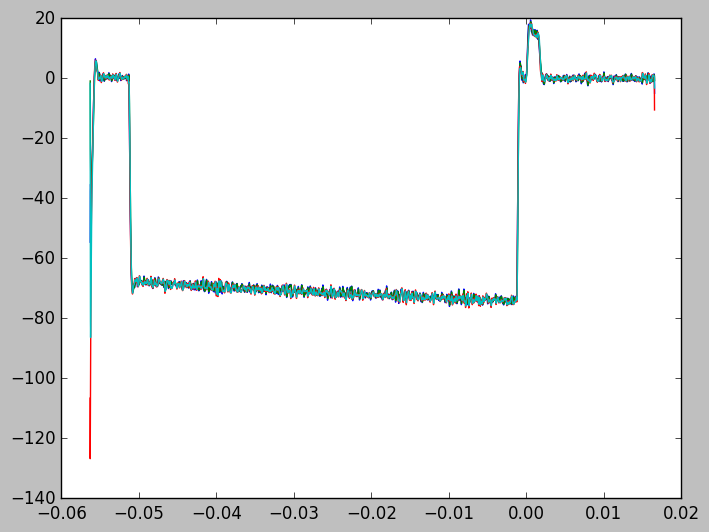

In [11]:
for li in lia.lis:
    plt.plot(li.t, li.df)
    plt.plot(li.t, signal.lfilter(*signal.butter(1, 5e3/(500e3)), x=li.df))

In [13]:
lic = phasekick.gr2lock(fh['control/0000'])
m = phasekick.masklh(li.t, -1e-3, 4e-3)
mc = phasekick.masklh(lic.t, -1e-3, 4e-3)

In [14]:
mpl.rc('font', size=10)

In [15]:
def cumsum_zero(x, i):
    cumsum = np.cumsum(x)
    return cumsum - cumsum[i]

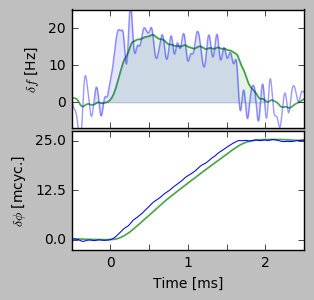

In [16]:
fig, ax = plt.subplots(nrows=2, figsize=(3.0, 3.0))
fig.subplots_adjust(hspace=0.02)
m_fill1 = phasekick.masklh(lia.t, -2e-4, 2e-3)
m_fill4 = phasekick.masklh(lia4.t, -2e-4, 2e-3)
i0 = np.argmax(abs(lia.t) <= 0.5e-6) # Index where t = 0
ax[0].fill_between(lia4.t[m_fill4]*1e3, lia4.df[m_fill4], color='b', alpha='0.1') 
ax[0].fill_between(lia.t[m_fill1]*1e3, lia.df[m_fill1], color='g', alpha='0.1') 
ax[0].plot(lia4.t*1e3, lia4.df, linewidth=1, alpha=0.4)
ax[0].plot(lia.t*1e3, lia.df, alpha=0.7, linewidth=1.25, zorder=0)
# ax[0].plot(lia1.t*1e3, lia1.df, 'm', linewidth=1.5, zorder=0)
ax[1].plot(lia4.t*1e3, cumsum_zero(lia4.df, i0)*1e-3, linewidth=0.75, alpha=1, zorder=2)
ax[1].plot(lia.t*1e3, cumsum_zero(lia.df, i0)*1e-3, alpha=0.7, linewidth=1.25, zorder=1)
# ax[1].plot(lia1.t*1e3, cumsum_zero(lia1.df, i0)*1e-3, 'm', alpha=0.5, linewidth=1.75, zorder=0)
ax[1].set_xlabel("Time [ms]")
ax[0].set_ylabel("$\\delta f$ [Hz]")
ax[0].set_ylim(-7, 25)
ax[1].set_ylabel("$\\delta \\phi$ [mcyc.]")
ax[1].set_xlim(-0.5, 2.5)
ax[0].set_xlim(-0.5, 2.5)
ax[1].set_ylim(-2.5, 27.5)
ax[1].set_yticks(np.linspace(0, 25, 3))
ax[0].set_yticks(np.linspace(0, 20, 3))
ax[0].set_xticklabels([""])
ax[1].set_xticklabels(["", 0, "", 1, "", 2, ""])
fig.savefig('../../figs/05-0a.pdf', bbox_inches='tight', transparent=True)

In [19]:
lia6 = gr2lock_both(fh, '0000', 4e3*factor, 15e3*factor, t1=0, t2=1.5e-3)

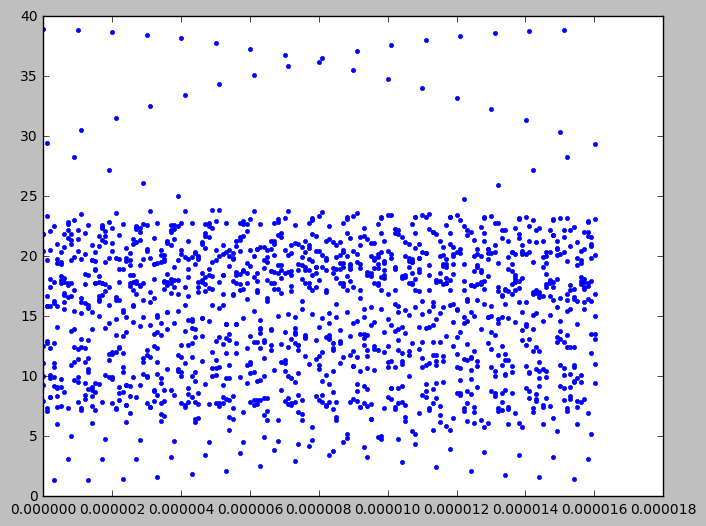

In [20]:
mm = phasekick.masklh(lia6.t, 0, 1.5e-3)
plt.plot(lia6.t % 16.1e-6, lia6.df, '.')

In [21]:
lia60 = gr2lock_both(fh, '0016', 4e3*factor, 15e3*factor, t1=0, t2=1.5e-3)

In [22]:
lia61 = gr2lock_both(fh, '0048', 4e3*factor, 15e3*factor, t1=0, t2=1.5e-3)
lia62 = gr2lock_both(fh, '0032', 4e3*factor, 15e3*factor, t1=0, t2=1.5e-3)

In [23]:
def period(t, T):
    return (t % T) / T

In [24]:
tt = period(lia6.t, 16.125e-6)

In [25]:
def func(t, A, B):
    return A*np.cos(2*np.pi*t) + B * np.sin(2*np.pi*t)

In [26]:
from scipy import optimize

In [27]:
def Amatrix(t):
    return np.c_[np.cos(2*np.pi*t), np.sin(2*np.pi*t)]

In [28]:
A = Amatrix(tt)

In [29]:
lia6.x.reshape((1, -1))

array([[-45.50289365, -36.73233941, -22.24318253, ..., -48.94016673,
        -59.692348  , -61.82688194]])

In [30]:
outs = linalg.lstsq(A, lia6.x)
coeffs = outs[0]

In [31]:
# plt.plot(period(lia6.t, 16.125e-6), lia6.x, '.')
# plt.plot(tt, np.dot(A, coeffs), '.')

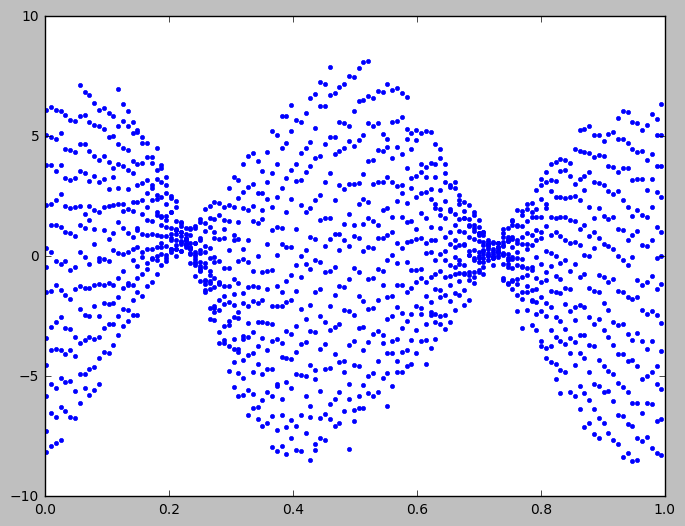

In [32]:
plt.plot(tt, np.dot(A, coeffs) - lia6.x, '.')

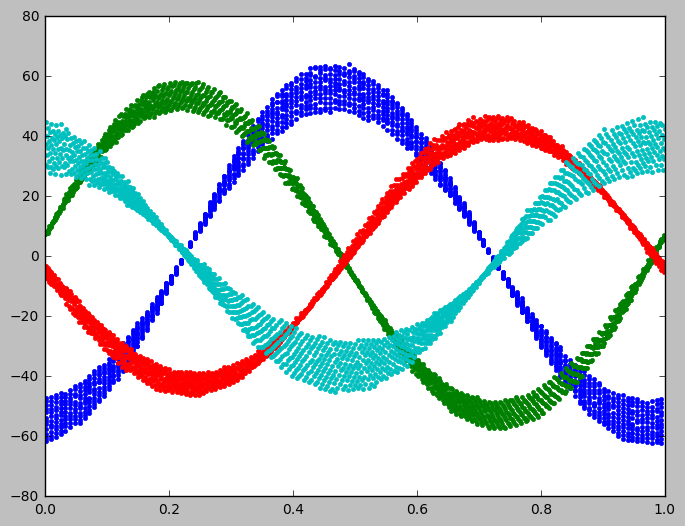

In [33]:
plt.plot(period(lia6.t, 16.125e-6), lia6.x, '.')
plt.plot(period(lia60.t, 16.138e-6), lia60.x, '.')
plt.plot(period(lia61.t, 16.115e-6), lia61.x, '.')
plt.plot(period(lia62.t, 16.135e-6), lia62.x, '.')

In [40]:
lia1 = li

(-1, 5)

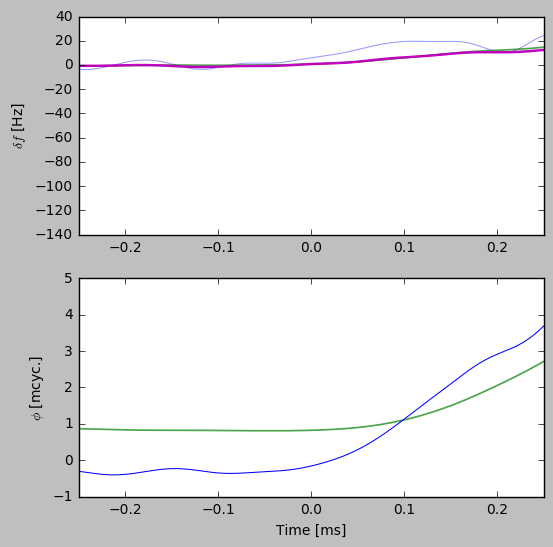

In [37]:
fig, ax = plt.subplots(nrows=2, figsize=(6, 6))
m_fill = phasekick.masklh(lia1.t, -2e-4, 1.8e-3)
# ax[0].fill_between(lia1.t[m_fill]*1e3, lia1.df[m_fill], color='m', alpha='0.2') 
ax[0].plot(lia4.t*1e3, lia4.df, linewidth=0.75, alpha=0.4)
ax[0].plot(lia.t*1e3, lia.df, alpha=0.7, linewidth=1.25)
ax[0].plot(lia1.t*1e3, lia1.df, 'm', linewidth=1.75)
ax[1].plot(lia4.t*1e3, np.cumsum(lia4.df)*1e-3, linewidth=0.75, alpha=1, zorder=2)
ax[1].plot(lia.t*1e3, np.cumsum(lia.df)*1e-3, alpha=0.7, linewidth=1.25, zorder=1)
ax[1].plot(lia1.t*1e3, np.cumsum(lia1.df)*1e-3, 'm', alpha=0.5, linewidth=1.75, zorder=0)
ax[0].set_xlim(-0.25, 0.25)
ax[1].set_xlabel("Time [ms]")
ax[0].set_ylabel("$\\delta f$ [Hz]")
ax[1].set_ylabel("$\\phi$ [mcyc.]")
ax[1].set_xlim(-0.25, 0.25)
ax[1].set_ylim(-1, 5)
# fig.savefig('../../figs/05-0a.pdf', bbox_inches='tight', transparent=True)

In [42]:
lis = lia.lis

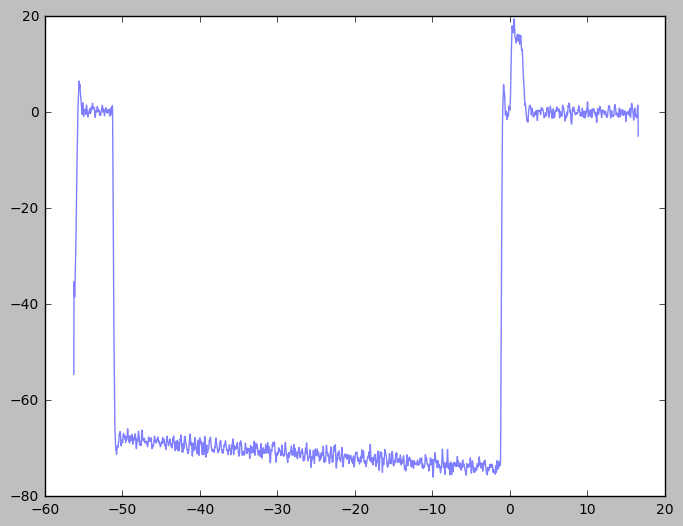

In [43]:
for li in lis[::2]:
    plt.plot(li.t*1e3, li.df, alpha=0.5)

In [45]:
dout = {}
datasets = fh['control'].keys()
for key, fname in tqdm(d.items()):
    lis = []
    with h5py.File(fname, 'r') as f:
        for ds in datasets:
            lis.append(gr2lock_both(f, ds, 1e3*factor, 4e3*factor, -1e-3, 2.5e-3))
    
    dout[key] = lis

100%|██████████| 5/5 [00:23<00:00,  4.81s/it]


In [46]:
dphase = {}
for key, lis in tqdm(dout.items()):
    pks = []
    for li in lis:
        m = phasekick.masklh(li.t, -2e-4, 1.8e-3)
        pks.append(np.sum(li.df[m])* (li.t[m][-1] - li.t[m][0]) / len(li.df[m]) * 1e3)
    dphase[key] = np.array(pks)

100%|██████████| 5/5 [00:00<00:00, 28.66it/s]


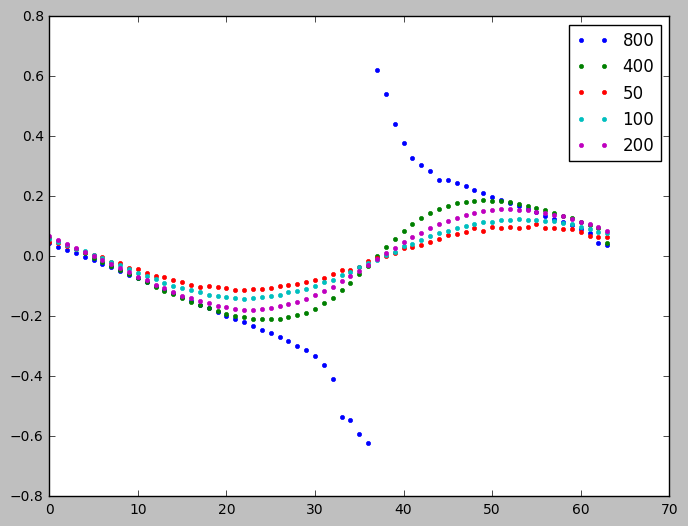

In [47]:
for key, val in dphase.items():
    plt.plot(val/key, '.', label=key)

plt.legend()

In [52]:
d_psd = {}
for key, lias in dout.items():
    d_psd[key] = avg_psd(lias)

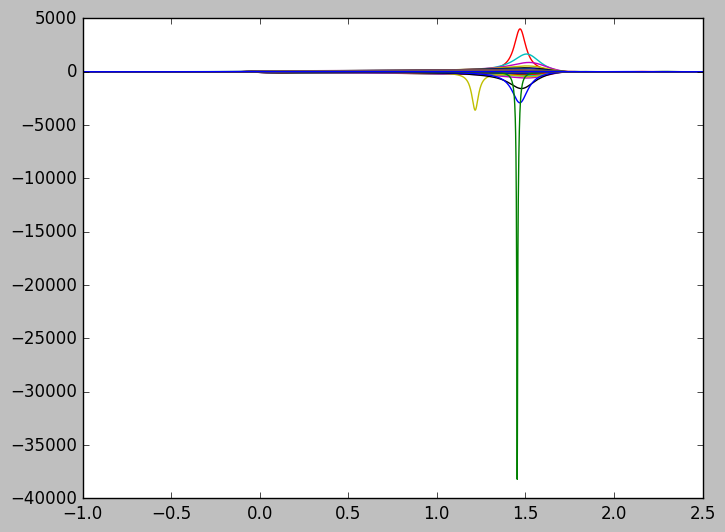

In [54]:
d8 = dout[800]
for lia in d8:
    plt.plot(lia.t * 1e3, lia.df)

In [55]:
problem_ds = {}
for key, lias in enumerate(d8):
    if np.any(abs(lias.df) > 1000):
        problem_ds[key] = val

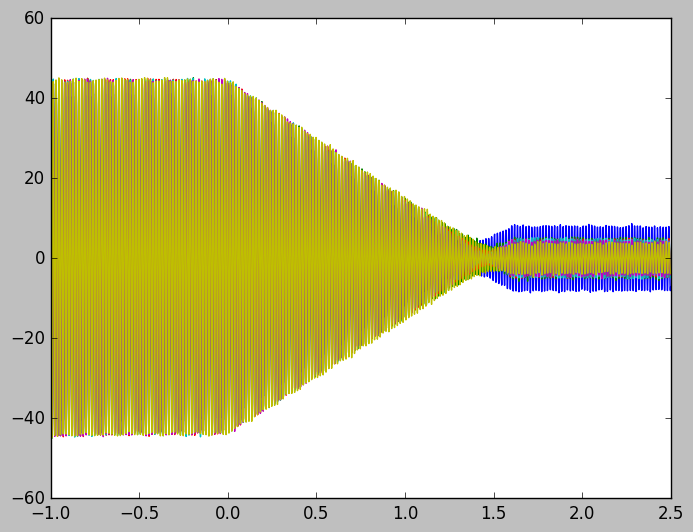

In [56]:
for i in problem_ds.keys():
    plt.plot(d8[i].t*1e3, d8[i].x)

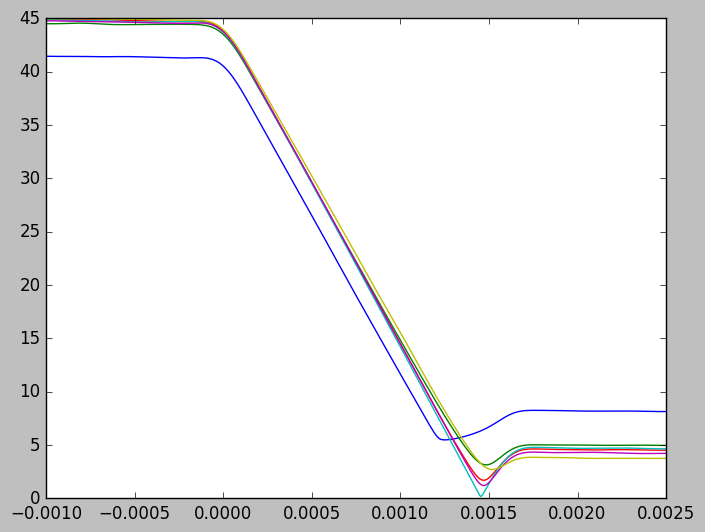

In [57]:
for i in problem_ds.keys():
    plt.plot(d8[i].t, d8[i].A)

All that's happening for the problem datasets is that I am ringing the cantilever amplitude so dramatically that the lock-in amplifier reads the dramatically fast change in amplitude as a change in phase?

In [58]:
freq2, psd2 = avg_psd(d8[32:40])

(-5000, 5000)

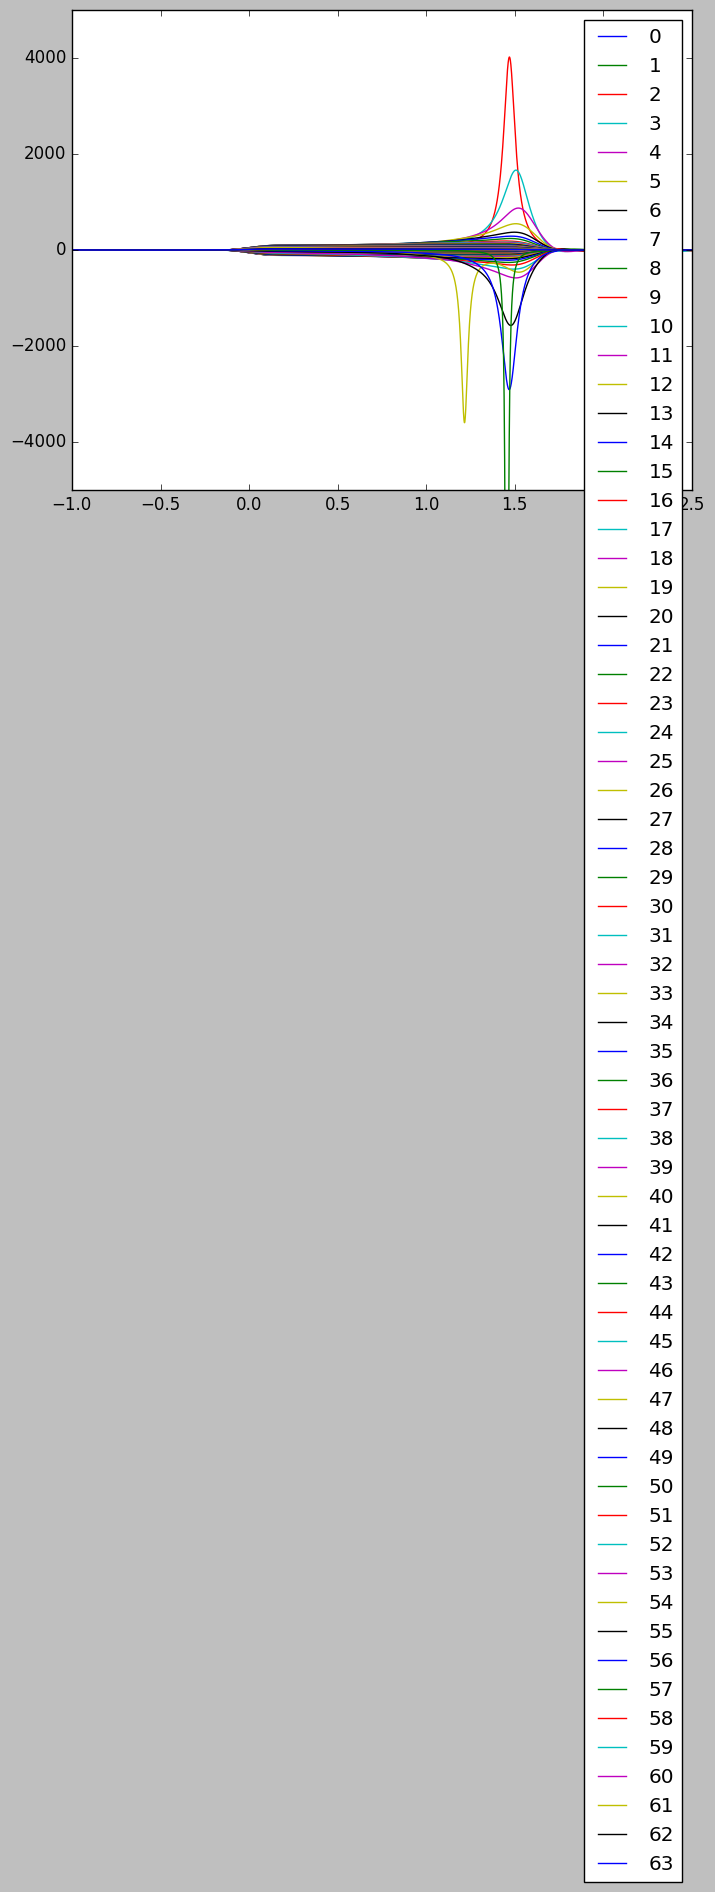

In [59]:
for i, li in enumerate(d8):
    plt.plot(li.t*1e3, li.df, label=i)

plt.legend()
plt.ylim(-5000, 5000)

(1e-08, 0.01)

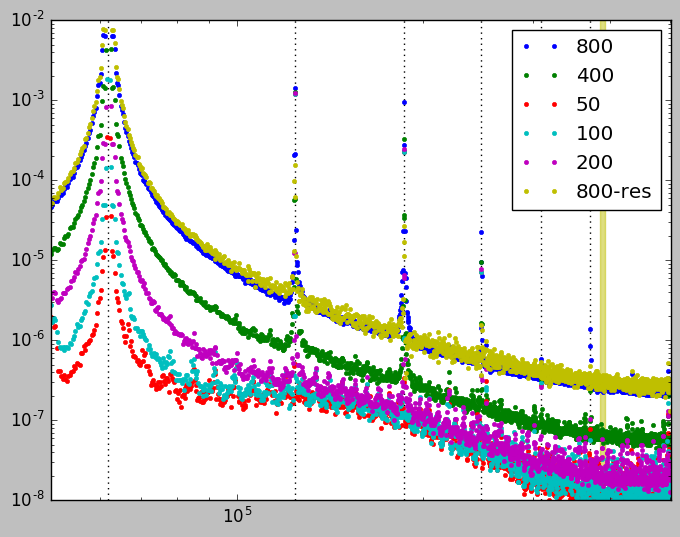

In [72]:
for key, (freq, psdm) in d_psd.items():
    plt.loglog(freq, psdm, '.', label=key)

plt.loglog(freq2, psd2, '.', label='800-res')
fc = 62e3
for i in xrange(1, 7):
    plt.axvline(i * fc, linestyle=':', zorder=0, color='k')
plt.axvspan(6.21*fc, 6.33*fc, zorder=0, alpha=0.5, color='y')
plt.legend()
plt.xlim(0.5e5, 5.01e5)
plt.ylim(1e-8, 1e-2)

In [64]:
(4.694**2 / 1.875**2) * 62e3

388575.4117688889

In [65]:
(4.694**2 / 1.875**2)

6.267345351111111

In [66]:
6.27 * 

388740.0

In [ ]:
datasets = fh['control'].keys()
lis = []
for ds in datasets:
    lis.append(gr2lock_both(fh, ds, 1e3*factor, 4e3*factor, -1e-3, 2.5e-3))

In [ ]:
pks = []
for li in lis:
    m = phasekick.masklh(li.t, -2e-4, 1.8e-3)
    pks.append(np.sum(li.df[m])* (li.t[m][-1] - li.t[m][0]) / len(li.df[m]) * 1e3)

In [ ]:
plt.plot(pks[:-1], 'b.')

In [ ]:
np.mean(pks[:-1])

In [ ]:
import sigutils

In [ ]:
li_ma = lockin.LockIn(li.t, li.x, 1e6)

In [ ]:
N_avg = lia.fs / (np.mean(lia.df) + lia.f0)

In [ ]:
def farey(x, N):
    a, b = 0, 1
    c, d = 1, 1
    while (b <= N and d <= N):
        mediant = float(a+c)/(b+d)
        if x == mediant:
            if b + d <= N:
                return a+c, b+d
            elif d > b:
                return c, d
            else:
                return a, b
        elif x > mediant:
            a, b = a+c, b+d
        else:
            c, d = a+c, b+d
 
    if (b > N):
        return c, d
    else:
        return a, b

In [ ]:
farey(1.0/N_avg, 1000)

In [ ]:
li_ma = lockin.LockIn(li.t, li.x, 1e6)

In [ ]:
li_ma.run(fir=np.ones(662)/662)
li_ma.phase()

In [ ]:
plt.plot(li_ma('t')*1e3, li_ma('A'))
plt.xlim(-1, 4)

In [ ]:
sigutils.bode_z(np.ones(662)/662, fs=1e6, xlog=True, xlim=(1e3, 2.5e5))

In [ ]:
plt.plot(lia4.t*1e3, lia4.A, alpha=0.4)
plt.plot(lia.t*1e3, lia.A, alpha=0.7, linewidth=1.5)
plt.plot(lia1.t*1e3, lia1.A, linewidth=2)

In [ ]:
plt.plot((li.t[m] + lic.t[m])*1e3/2, (li.df[m] + lic.df[mc])/2)
plt.xlim(-1, 4)

In [ ]:
li = phasekick.gr2lock(fh['data/0000'])

In [ ]:
plt.plot(li('t')*1e3, li('A'))